# Logistic Regression with SPU

*The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.*

[SPU](https://spu.antfin-inc.com/) is a domain specific compiler and runtime suite, which provides provable secure computation service. SPU compiler uses [XLA](https://www.tensorflow.org/xla) as its front-end IR, which supports diverse AI framework (like Tensorflow, JAX and PyTorch). SPU compiler translates XLA to an IR which could be interpreted by the SPU runtime. Currently SPU team highly recommends using [JAX](https://github.com/google/jax) as the frontend.

## Learning Objectives:

After doing this lab, you'll know how to:

* How to write a Logistic Regression trainning program with JAX.
* How to convert a JAX program to a SPU(MPC) program painlessly.

In this lab, we select [Breast Cancer](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)) as the dataset. We need to decide whether cancer is malignant or benign with 30 features. In the MPC program, two parties will train the model jointly and each party would provide half of features(15).

While, first, let's just forget MPC settings and just write a Logistic Regression trainning program with JAX directly.

## Train a model with JAX

### Load the Dataset


We are going to split the whole dataset into train and test subsets after normalization.
* `load_train_dataset` returns train subsets. In order to simulate trainning with vertical dataset splitting, the `party_id` is provided.
* `load_test_dataset` returns test subsets.

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_train_dataset(party_id=None) -> (np.ndarray, np.ndarray):
    features, label = load_breast_cancer(return_X_y=True)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    X_train, _, y_train, _ = train_test_split(
        features, label, test_size=0.8, random_state=42
    )

    if party_id:
        if party_id == 1:
            return X_train[:, 15:], _
        else:
            return X_train[:, :15], y_train
    else:
        return X_train, y_train


def load_test_dataset():
    features, label = load_breast_cancer(return_X_y=True)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    _, X_test, _, y_test = train_test_split(
        features, label, test_size=0.8, random_state=42
    )
    return X_test, y_test


### Define the Model

First, let's define the loss function, which is a negative log-likelihood in our case.

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)


# Training loss is the negative log-likelihood of the training examples.
def loss(W, b, inputs, targets):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.mean(jnp.log(label_probs))


Second, let's define a single train step with SGD optimizer. Just to remind you, x1 represents 15 features from one party while x2 represents the other 15 features from the other party.

In [3]:
from jax import value_and_grad


def train_step(W, b, x1, x2, y, learning_rate):
    x = jnp.concatenate([x1, x2], axis=1)
    loss_value, Wb_grad = value_and_grad(loss, (0, 1))(W, b, x, y)
    W -= learning_rate * Wb_grad[0]
    b -= learning_rate * Wb_grad[1]
    return loss_value, W, b



Last, let's build everything together as a `fit` method which returns the model and losses of each epoch.

In [4]:
def fit(W, b, x1, x2, y, epochs=1, learning_rate=1e-2):
    losses = jnp.array([])
    for _ in range(epochs):
        l, W, b = train_step(W, b, x1, x2, y, learning_rate=learning_rate)
        losses = jnp.append(losses, l)
    return losses, W, b


### Validate the Model

We could use the AUC to validate a binary classification model.

In [5]:
from sklearn.metrics import roc_auc_score


def validate_model(W, b, X_test, y_test):
    y_pred = predict(W, b, X_test)
    return roc_auc_score(y_test, y_pred)


If you are interested, we could also plot loss after each epoch of trainning.

In [6]:
import matplotlib.pyplot as plt


def plot_losses(losses):
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')


### Have a try!

Let's put everything we have together and train a LR model!

auc=0.9469048608226007


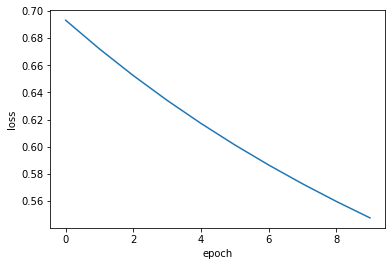

In [7]:
%matplotlib inline

# Load the data
x1, _ = load_train_dataset(party_id=1)
x2, y = load_train_dataset(party_id=2)

# Hyperparameter
W = jnp.zeros((30,))
b = 0.0
epochs = 10
learning_rate = 1e-2

# Train the model
losses, W, b = fit(W, b, x1, x2, y, epochs=10, learning_rate=1e-2)

# Plot the loss
plot_losses(losses)

# Validate the model
X_test, y_test = load_test_dataset()
auc=validate_model(W,b, X_test, y_test)
print(f'auc={auc}')


Just remember the plot and AUC here since we would like to do the similar thing with SPU!

## Train a Model with SPU

At this part, we are going to show you how to do the similar trainning with MPC securely!

### Init the Environment

We are going to init three virtual devices on our physical environment.
- alice, bob：Two PYU devices for local plaintext computation.
- spu：SPU device consists with alice and bob for MPC secure computation.

In [8]:
import secretflow as sf

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob'], num_cpus=8, log_to_driver=True)

alice, bob = sf.PYU('alice'), sf.PYU('bob')
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))


2022-06-16 12:58:40.997214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


### Load the Dataset

we instruct alice and bob to load the train subset repectively.

In [9]:
x1, _ = alice(load_train_dataset)(party_id=1)
x2, y = bob(load_train_dataset)(party_id=2)

x1, x2, y


(<secretflow.device.device.pyu.PYUObject at 0x7ff47c3654c0>,
 <secretflow.device.device.pyu.PYUObject at 0x7ff304160e50>)

Before trainning, we need to pass hyperparamters and all data to SPU device. SecretFlow provides two methods:
- secretflow.to: transfer a PythonObject or DeviceObject to a specific device.
- DeviceObject.to: transfer the DeviceObject to a specific device.

In [10]:
device = spu

W = jnp.zeros((30,))
b = 0.0

W_, b_, x1_, x2_, y_ = (
    sf.to(device, W),
    sf.to(device, b),
    x1.to(device),
    x2.to(device),
    y.to(device),
)


### Train the model

Now we are ready to train a LR model with SPU. After trainning, losses and model are SPUObjects which are still secret.

In [11]:
losses, W_, b_ = device(fit, static_argnames=['epochs'], num_returns=3)(
    W_, b_, x1_, x2_, y_, epochs=10, learning_rate=1e-2
)

losses, W_, b_


(<secretflow.device.device.spu.SPUObject at 0x7ff45ca25f10>,
 <secretflow.device.device.spu.SPUObject at 0x7ff45ca3c820>)

### Reveal the result

In order to check losses and model, we need to convert SPUObject(secret) to Python object(plaintest). SecretFlow provide `sf.reveal` to convert any DeviceObject to Python object.

> Be care with `sf.reveal`，since it may result in secret leak。

(pid=2435073) 2022-06-16 12:58:46.302191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(pid=2435072) 2022-06-16 12:58:46.379120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(_run pid=24

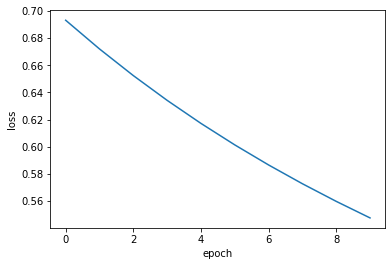

In [12]:
%matplotlib inline

losses = sf.reveal(losses)

plot_losses(losses)


Finally, let's validate the model with AUC.

In [13]:
auc = validate_model(sf.reveal(W_), sf.reveal(b_), X_test, y_test)
print(f'auc={auc}')


auc=0.9469048608226007


2022-06-16 13:00:31,412	ERROR worker.py:478 -- print_logs: Connection closed by server.
2022-06-16 13:00:31,416	ERROR worker.py:1247 -- listen_error_messages_raylet: Connection closed by server.
2022-06-16 13:00:31,420	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.


You may find the model from SPU trainning program achieve the same AUC as JAX program.

This is the end of lab.